# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## План реализации проекта

1. [Подготовка данных. Импорт библиотек](#step_1)
- [1.1 Грубая предобработка данных](#step_1.1)
- [1.2 Предобработка данных для задач машинного обучения](#step_1.2)
2. [Исследование задачи](#step_2)
- [2.1 Определение выборок](#step_2.1)
- [2.2 Обучение модели](#step_2.2)
- [2.3 Проверка адекватности модели](#step_2.3)
- [2.4 Подбор оптимального порога](#step_2.4)
3. [Борьба с дисбалансом классов](#step_3)
- [3.1 Метод upsampling](#step_3.1)
- [3.2 Поиск наилучшей модели на обучении upsampled выборки](#step_3.2)
- [3.3 Метод downsampling](#step_3.3)
- [3.4 Поиск наилучшей модели на обучении downsampled выборки](#step_3.4)
4. [Тестирование модели](#step_4)
5. [Общий вывод](#step_5)

## Описание данных

**Признаки**
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

**Целевой признак**
- *Exited* — факт ухода клиента

## 1. Подготовка данных<a id='step_1'></a>

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

Откроем файл с данными и исследуем его:

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Чтобы ничего не упустить, составим предварительный план предобработки данных:

### 1.1 Грубая предобработка данных<a id='step_1.1'></a>

#### План грубой предобработки данных

1. Привести названия столбцов к нижнему регистру
1. *RowNumber* - убрать
1. *Tenure* - заполнить/удалить пропуски


#### 1. Приведем названия столбцов к нижнему регистру

In [6]:
df.columns = [str.lower(i) for i in df.columns]

#### 2. Удалим столбец *RowNumber*

In [7]:
df = df.drop('rownumber', axis=1)

In [8]:
df.head(3)

,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


#### 3. Разберемся с пропусками в столбце *Tenure*

Восстановить данные с достаточной для прадоподобия точностью у нас нет возможности. Заполнять пропуски какой-либо из статистик нецелесообразно т.к. такие объекты могут в худшую сторону повлиять на качество обучения модели. Поэтому, просто отбросим объекты с пропусками.

In [9]:
df = df.dropna()

In [10]:
df.shape

(9091, 13)

###  Промежуточный вывод:

Данные очищены от лишних столбцов. Удалены пропуски. Датафрейм готов к более тонкой подготовке данных для машинного обучения.

### 1.2 Предобработка данных для задач машинного обучения<a id='step_1.2'></a>

Как мы знаем, чтобы модель лучше поняла закономерности в данных, эти самые данные должны быть определенным образом подготовлены для алгоритма обучения. Имея такую цель, определим план предобработки данных:

**Вспомним, какие есть типы признаков, и какими методами они обрабатываются:**

- Количественный признак ---> Нормирование
- Категориальный признак ---> Кодирование. Метод OHE
- Ранговый (порядковый) признак ---> Нормирование

#### План тонкой предобработки данных

1. Столбец *customerid* нам не нужен. Он внесет лишний шум в данные. Отбрасываем
1. Столбец *surname* - аналогично.
1. Признак *creditscore* - представляет собой набор числовых признаков. Для нашей задачи он может оказаться важен. Нужно его только нормировать.
1. Признак *geography* категориальный признак. Тоже представляет ценность. Но его нужно закодировать методом OHE.
1. Признак *gender* - категориальный бинарный признак. Аналогично п.4
1. Признак *age* - количественный признак. Нормировать.
1. Признак *tenure* - ранговый признак. Нормировать
1. Признак *balance* - количественный признак. Нормировать
1. Признак *numofproducts* - ранговый признак. Нормировать
1. Признак *hascrcard* - категориальный бинарный признак. В данном случае, он уже подготовлен. Оставляем без изменений
1. Признак *isactivemember* - категориальный бинарный признак. В данном случае, он уже подготовлен. Оставляем без изменений
1. Признак *estimatedsalary* - количественный признак. Нормировать
1. Проверка на **мультиколлинеарность**

#### 1. Отбросим лишние столбцы  п.1 - п.2

Будем собирать все признаки в отдельный датафрейм

In [11]:
df_ml = df.drop(['customerid', 'surname'], axis=1)

In [12]:
df_ml.head(3)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


#### 2. Категориальные признаки. Обработаем сразу все**

Здесь пути расходятся. Признаки для линейных моделей закодируем методом - "OHE", а для моделей деревьев - методом "Ordinal".

In [13]:
df_ml_ohe = pd.get_dummies(df_ml, drop_first=True)

In [14]:
df_ml_ohe.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


И снова преобразуем столбцы к нижнему регистру:

In [15]:
df_ml_ohe.columns = [str.lower(i) for i in df_ml_ohe.columns]

In [16]:
df_ml_ohe.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


Проверим, что ничего на пути не растеряли:

In [17]:
df_ml_ohe.shape

(9091, 12)

Теперь закодируем данные методом Ordinal

In [18]:
encoder = OrdinalEncoder()
df_ml_ord = pd.DataFrame(encoder.fit_transform(df_ml),
                            columns=df_ml.columns)

In [19]:
df_ml_ord.head(3)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0,1.0
1,215.0,2.0,0.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0,0.0
2,109.0,0.0,0.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0,1.0


In [20]:
df_ml_ord.shape

(9091, 11)

Теперь имеем два датафрейма с разной кодировкой категориальных признаков.

#### 3. Количественные признаки. Нормирование

Отделим целевой признак от остальных:

Для выборки **OHE**:

In [21]:
target_ohe = df_ml_ohe['exited']
features_ohe = df_ml_ohe.drop('exited', axis=1)

print(target_ohe.shape)
print(features_ohe.shape)

(9091,)
(9091, 11)


Для выборки **Ordinal**:

In [22]:
target_ord = df_ml_ord['exited']
features_ord = df_ml_ord.drop('exited', axis=1)

print(target_ord.shape)
print(features_ord.shape)

(9091,)
(9091, 10)


**Разбиение на выборки**

Для того, чтобы избежать "подглядывания" моделей, перед нормированием признаков, разобъем данные на обучающую и тестовую выборку: 

А для того, чтобы тестировать оптимальные пороги, создадим еще и валидационную выборку.

Для выборки **OHE**:

In [23]:
feat_ohe_train_valid, features_ohe_test, target_ohe_train_valid, target_ohe_test = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(
    feat_ohe_train_valid, target_ohe_train_valid, test_size=0.25, random_state=12345)

print(features_ohe_train.shape, features_ohe_valid.shape, features_ohe_test.shape)

(5113, 11) (1705, 11) (2273, 11)


Для выборки **Ordinal**:

In [24]:
feat_ord_train_valid, features_ord_test, target_ord_train_valid, target_ord_test = train_test_split(
    features_ord, target_ord, test_size=0.25, random_state=12345)

features_ord_train, features_ord_valid, target_ord_train, target_ord_valid = train_test_split(
    feat_ord_train_valid, target_ord_train_valid, test_size=0.25, random_state=12345)

print(features_ord_train.shape, features_ord_valid.shape, features_ord_test.shape)

(5113, 10) (1705, 10) (2273, 10)


**Нормирование**

Теперь выпишем названия столбцов с числовыми признаками, которые будем нормировать:

In [25]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

Вызовем модель для нормирования данных, и обучим ее:

In [26]:
scaler = StandardScaler()
scaler.fit(features_ohe_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

Заменим числовые значения признаков на нормированные:

Для выборки **OHE**:

In [27]:
pd.options.mode.chained_assignment = None

features_ohe_train[numeric] = scaler.transform(features_ohe_train[numeric])
features_ohe_valid[numeric] = scaler.transform(features_ohe_valid[numeric])
features_ohe_test[numeric] = scaler.transform(features_ohe_test[numeric])

print(features_ohe_train.shape, features_ohe_valid.shape, features_ohe_test.shape)

(5113, 11) (1705, 11) (2273, 11)


In [28]:
features_ohe_train.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
2142,0.429837,-0.393424,0.330914,0.575644,-0.914996,1,0,1.313694,0,0,1
7361,0.450392,-0.298659,-0.351604,-1.232909,-0.914996,1,0,1.462020,0,0,0
7102,-1.327676,-0.014364,-1.034123,0.579934,0.799951,1,0,-0.052254,0,0,1


Для выборки **Ordinal**:

In [29]:
features_ord_train[numeric] = scaler.transform(features_ord_train[numeric])
features_ord_valid[numeric] = scaler.transform(features_ord_valid[numeric])
features_ord_test[numeric] = scaler.transform(features_ord_test[numeric])

print(features_ord_train.shape, features_ord_valid.shape, features_ord_test.shape)

(5113, 10) (1705, 10) (2273, 10)


In [30]:
features_ord_train.head(3)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
1935,-3.609359,0.0,1.0,-2.099196,0.330914,-1.195114,-2.629944,1.0,0.0,-1.593504
6676,-3.588803,0.0,0.0,-2.004431,-0.351604,-1.232909,-2.629944,1.0,0.0,-1.586603
6441,-5.366872,0.0,1.0,-1.720136,-1.034123,-1.194793,-0.914996,1.0,0.0,-1.655650


#### 4. Проверка на мультиколлинеарность

Построим матрицу корреляции признаков:

In [31]:
features_ohe_train.corr()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
creditscore,1.000000,-0.011227,0.014629,-0.002075,0.008782,-0.008597,0.048959,-0.004808,-0.009246,0.018275,-0.023527
age,-0.011227,1.000000,-0.016777,0.030002,-0.033485,-0.030066,0.079501,0.000897,0.043795,-0.002912,-0.027645
tenure,0.014629,-0.016777,1.000000,0.007427,-0.000996,0.040740,-0.046618,0.008825,0.000974,0.005558,0.002027
balance,-0.002075,0.030002,0.007427,1.000000,-0.298156,-0.016434,0.002651,0.008638,0.393531,-0.129325,0.019562
numofproducts,0.008782,-0.033485,-0.000996,-0.298156,1.000000,0.011819,0.003973,0.017717,-0.020771,0.000626,-0.032965
hascrcard,-0.008597,-0.030066,0.040740,-0.016434,0.011819,1.000000,-0.011766,-0.008685,0.008230,-0.003014,-0.005517
isactivemember,0.048959,0.079501,-0.046618,0.002651,0.003973,-0.011766,1.000000,-0.006224,-0.007776,0.005987,0.036281
estimatedsalary,-0.004808,0.000897,0.008825,0.008638,0.017717,-0.008685,-0.006224,1.000000,0.015949,0.001836,-0.011676
geography_germany,-0.009246,0.043795,0.000974,0.393531,-0.020771,0.008230,-0.007776,0.015949,1.000000,-0.329426,-0.021581
geography_spain,0.018275,-0.002912,0.005558,-0.129325,0.000626,-0.003014,0.005987,0.001836,-0.329426,1.000000,-0.003568


Сильной корреляции между признаками не выявлено, значит можно считать их независимыми. 

UPD(15.03.21): Большой разницы между таблицами ohe и ord нет, поэтому строить матрицу корреляции для ord не станем.

### Вывод

Признаки подготовлены для передачи в модель обучения. Примерно 10% данных пришлось пожертвовать из-за наличия у них пропусков. 

Проведена проверка на мультиколлинеарность. Все признаки являются независимыми. 

Числовые фичи отмасштабированы.

## 2. Исследование задачи<a id='step_2'></a>

Посмотрим на величину дисбаланса классов:

In [32]:
target_ohe.value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

Число текущих клиентов банка почти в 4 раза больше числа тех, кто от услуг банка отказался

Попробуем обучить модель без учета дисбаланса. В качестве самой модели возьмем **RandomForestClassifier**

### 2.1 Обучение модели<a id='step_2.1'></a>

Создадим модель случайного леса:

In [33]:
model = RandomForestClassifier(random_state=42)

Перебирать лучшие параметры модели вручную не станем. С этим лучше и быстрее справится **RandomizedSearchCV**

Определим параметры, которые будет подбирать модель. Ограничимся глубиной дерева, количеством деревьев, минимальным количеством объектов в узле, и минимальным количеством объектов в листе.

In [34]:
params = {'max_depth':range(1,20,2),
          'n_estimators':range(1,100,5),
          'min_samples_split':range(2,20,2),
          'min_samples_leaf':range(1,20,2)}

In [35]:
clf = RandomizedSearchCV(model, params, random_state=42)

In [36]:
%%time
clf.fit(features_ord_train, target_ord_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 4.8 s, sys: 9.13 ms, total: 4.81 s
Wall time: 5.28 s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs

In [37]:
best_model = clf.best_estimator_

Оценка **Accuracy:**

In [38]:
best_model.score(features_ord_test, target_ord_test)

0.8622965244170699

### 2.3 Проверка адекватности модели<a id='step_2.3'></a>

Создадим лжемодель. Пусть предсказывает всем объектам 0. Оценим accuracy такой модели.

In [39]:
all_zeros = pd.Series(data=0, index=target_ord_test.index)

Оценим accuracy:

In [40]:
accuracy_score(target_ord_test, all_zeros)

0.8015838099428069

Чтож, наша обученная модель действительно справляется с задачей классификации лучше, чем случайная модель. Но, как мы знаем, accuracy - не лучшая метрика для сравнения. Дополнительно, оценим модели с помощью ROC - кривой.

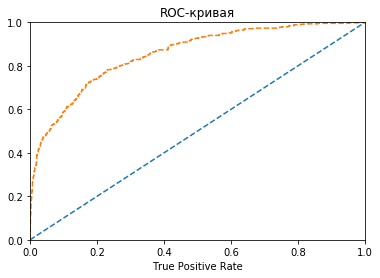

Площад под ROC-кривой обученной модели = 0.8543613290139489
Площад под ROC-кривой случайной модели = 0.5


In [41]:
probabilities_test_rf = best_model.predict_proba(features_ord_test)
probabilities_one_test = probabilities_test_rf[:, 1]

fpr, tpr, thresholds = roc_curve(target_ord_test, probabilities_one_test)

fpr_1, tpr_1, thresholds_1 = roc_curve(target_ord_test, all_zeros)

plt.figure()

plt.plot(fpr_1, tpr_1, linestyle='--')
plt.plot(fpr, tpr, linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

print('Площад под ROC-кривой обученной модели =', roc_auc_score(target_ord_test, probabilities_one_test))
print('Площад под ROC-кривой случайной модели =', roc_auc_score(target_ord_test, all_zeros))

Подводя промежуточный итог, посчитаем значение F-меры для нашей модели:

In [42]:
predicted = best_model.predict(features_ord_test)
print('F-мера обученной без учета дисбаланса классов модели =', f1_score(target_ord_test, predicted))

F-мера обученной без учета дисбаланса классов модели = 0.533532041728763


### 2.4 Подбор оптимального порога<a id='step_2.4'></a>

Так как главная метрика проекта это F-мера, то ее и будем стараться максимизировать:

Создадим функцию подбора оптимального порога. Пусть результатом ее работы будет датафрейм с оценкой f-меры для каждого значения порога.

In [43]:
#Версия 1.02 
def find_best_threshold(probabilities_valid, x_valid, y_valid, clf_name):
    
    data=pd.DataFrame({'clf':[], 'threshold':[], 'f1_score':[], 'roc_auc_score':[]})

    for threshold in np.arange(0.05, 1, 0.05):
        threshold_proba = np.where(probabilities_valid[:, 1] > threshold, 1, 0)
        score = f1_score(y_valid, threshold_proba)
        score_auc = roc_auc_score(y_valid, threshold_proba)
        data = data.append({'clf':clf_name, 
                            'threshold':threshold, 
                            'f1_score':score, 
                            'roc_auc_score':score_auc}, ignore_index=True)
    return data

Запишем результат работы функции в отдельный датафрейм:

In [44]:
probabilities_valid_rf = best_model.predict_proba(features_ord_valid)

In [45]:
disb_data_rf = find_best_threshold(probabilities_valid_rf, features_ord_valid, target_ord_valid, 'RFClassifier')

Не заглядывая внутрь, построим график измененния f-меры в зависимости от порога. И выведем максимальное значение, которое удалось найти:

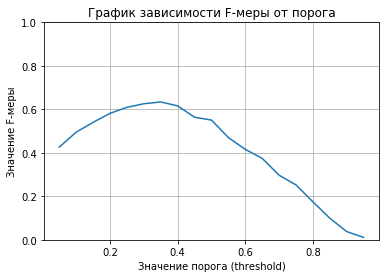

Наибольшее значение F-меры на валидационной выборке = 0.6339969372128638 при величине порога = 0.35000000000000003
Значение F-меры на тестовой выборке при том же пороге = 0.584295612009238


In [46]:
plt.plot(disb_data_rf.threshold, disb_data_rf.f1_score)
plt.ylabel('Значение F-меры')
plt.xlabel('Значение порога (threshold)')
plt.title('График зависимости F-меры от порога')
plt.grid(True)
plt.ylim([0,1]) 
plt.show()
        
print('Наибольшее значение F-меры на валидационной выборке =', disb_data_rf.query('f1_score == f1_score.max()')['f1_score'].values[0],
      'при величине порога =', disb_data_rf.query('f1_score == f1_score.max()')['threshold'].values[0])


probabilities_test_rf = best_model.predict_proba(features_ord_test)
threshold_proba = np.where(probabilities_test_rf[:, 1] > disb_data_rf.query('f1_score == f1_score.max()')['threshold'].values[0], 1, 0)
print('Значение F-меры на тестовой выборке при том же пороге =', f1_score(target_ord_test, threshold_proba))
      

### Вывод:

Наибольшее значение **F-меры** на тестовой выборке, обученной без учета дисбаланса классов модели = **0.58**

При наличии дисбаланса классов, такие метрики как **accuracy** практически не несут никакой информативности. Поэтому, в таком случае, нагляднее будет метрика **ROC AUC score**, которая вычисляет долю ошибок и правильных ответов. Она слабо зависит от дисбаланса.

Согласно некоторым популярным статьям таким как [эта](https://habr.com/ru/post/349078/) или вот [эта](https://qastack.ru/stats/247871/what-is-the-root-cause-of-the-class-imbalance-problem), получается, что проблема дисбаланса классов до сих пор актуальна и обсуждается. Вероятно, "не так страшен черт, как его малюют", и дисбаланс далеко не всегда сильно влияет на качество модели. Да, в задачах мультиклассификации, дисбаланс играет далеко не последнюю роль. Но, в задачах бинарной классификиации, с использованием моделей RandomForestClassifier, разный вес классов может не нести весомого вклада в качество модели.

Примем последнее утверждение в качетсве гипотезы, которую и проверим в следующем шаге.

## 3. Борьба с дисбалансом<a id='step_3'></a>

Рассмотрим 2 поднятых в обучающем курсе метода: **upsampling** и **downsampling**.

#### План борьбы с дисбалансом:

1. Увеличить вес положительного класса. Воспользоваться методом **upsampling**:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные;
2. Протестировать новую выборку на нескольких моделях. Отобрать модель с наибольшим значением F-меры

3. Уменьшить вес отрицательного класса. Воспользоваться методом **downsampling**
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросить часть из отрицательных объектов;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные;
4. Аналогично п.2

### 3.1 Метод upsampling<a id='step_3.1'></a>

Разделим выборку на отрицательные и положительные объекты, увеличим выборку положительных, перемешаем. Для этого напишем соответствующую функцию:

In [47]:
def sampling(features, target, how=['up', 'down']):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = int(np.ceil(features_zeros.shape[0] / features_ones.shape[0]))
    
    if how == 'up':
    
        features_sampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_sampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # могут возникать ошибки из-за особенностей округления. В этом случае примени более грубое округледние к fraction. Либо try / except    
    if how == 'down':
        fraction = 1 / repeat
        
        features_sampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
        
        target_sampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_sampled, target_sampled = shuffle(features_sampled, target_sampled, random_state=42)
    
    return features_sampled, target_sampled


Уравняем классы:

Отдельно для выборки OHE и выборки ORD:

Для выборки OHE:

In [48]:
features_ohe_upsampled, target_ohe_upsampled = sampling(features_ohe_train, target_ohe_train, how='up')

Проверим размеры выборок:

In [49]:
print(features_ohe_upsampled.shape)
print(target_ohe_upsampled.shape)

(8230, 11)
(8230,)


Для выборки ORD:

In [50]:
features_ord_upsampled, target_ord_upsampled = sampling(features_ord_train, target_ord_train, how='up')

In [51]:
print(features_ord_upsampled.shape)
print(target_ord_upsampled.shape)

(8230, 10)
(8230,)


### 3.2 Поиск наилучшей модели на обучении upsampled выборки<a id='step_3.2'></a>

Определим основные алгоритмы классификации, которые будем обучать:

- RandomForestClassifier
- KNeighborsClassifier
- LogisticRegression

В целях оптимизации процесса, заведем функцию, которая на вход будет получать тренировочные выборки, обучать несколько моделей, подбирать для каждой порог с максимальным значением F-меры, а на выходе отдавать словарь с наилучшими параметрами, и датафрейм со значениями F-меры:

In [52]:
#Версия 1.04 #Пробую сразу внедрить и CatBoost
def fit_models(x_ohe_train, y_ohe_train, x_ohe_valid, y_ohe_valid,
               x_ord_train, y_ord_train, x_ord_valid, y_ord_valid, model_params):
    # Запишем все модели для обучения
    models = [RandomForestClassifier, KNeighborsClassifier, LogisticRegression, CatBoostClassifier]
    
    # Здесь строковые имена моделей для записи в таблицу (небольшой костыль, т.к. имена из спика выше в строку не переводятся:()
    mod_names = {0:'RandomForestClassifier', 
                 1:'KNeighborsClassifier', 
                 2:'LogisticRegression', 
                 3:'CatBoostClassifier'}
   
    # Создадим пустой датафрейм, куда будем сохранять результаты обучения моделей
    f1_data = pd.DataFrame({'clf':[], 'threshold':[], 'f1_score':[], 'roc_auc_score':[]})
    # Создадим пустой словарь, куда будем сохранять лучшие параметры моделей
    best_model_params = {'RandomForestClassifier':{}, 
                         'KNeighborsClassifier':{}, 
                         'LogisticRegression':{}, 
                         'CatBoostClassifier':{}}
    
    
    for i in range(len(models)):
        if models[i] == LogisticRegression:
            x_train = x_ohe_train
            y_train = y_ohe_train
            x_valid = x_ohe_valid
            y_valid = y_ohe_valid
        else:
            x_train = x_ord_train
            y_train = y_ord_train
            x_valid = x_ord_valid
            y_valid = y_ord_valid
            # определяем модель
        if models[i] == KNeighborsClassifier:
            model_type = models[i]()
        else:
              model_type = models[i](random_state=42)
        clf = RandomizedSearchCV(model_type, model_params[i], random_state=42, cv=3, scoring='f1')
            # Запускаем алгоритм подбора параметров 
        clf.fit(x_train, y_train)
            # Определяем модель с наилучшими параметрами
        best_model = clf.best_estimator_
            # Сохраняем в словаре лучшие параметры
        best_model_params[mod_names[i]] = clf.best_params_

            # Находим массив вероятностей
        probabilities_valid = best_model.predict_proba(x_valid)

            # Запускаем алгоритм подбора оптимального порога для лучшей модели
        f1_data = f1_data.append(find_best_threshold(probabilities_valid, x_valid, y_valid, mod_names[i]), ignore_index=True) 

    #f1_data['average'] = (f1_data['f1_score'] + f1_data['roc_auc_score'])/2
    # На выходе получаем словарь параметров, и датафрейм с перебором порогов и значениями f-меры
    return best_model_params, f1_data

Определим массивы параметров для каждой модели (параметры для RandomForest уже лежат в переменной params)

In [53]:
params_knn = {'n_neighbors':range(3,9,1), 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size':range(5,50,5)}

params_lr = {'penalty':['l1', 'l2'], 
             'class_weight':['balanced', None],
             'max_iter': range(50, 150, 10),
             'solver': ['lbfgs', 'liblinear', 'saga']
}


params_cb= {'iterations': range(2,10,1), 
              'depth':range(2,10,1), 
              'learning_rate':range(1,10,1)
}

Сохраним все параметры списком, чтобы передать в функцию fit_models()

In [54]:
params_lst = [params, params_knn, params_lr, params_cb]

Все готово для обучения. Запустим написанную выше функцию, и найдем модели с наибольшим значением f-меры:

In [55]:
best_model_params, f1_data = fit_models(features_ohe_upsampled, target_ohe_upsampled, features_ohe_valid, target_ohe_valid,
                                        features_ord_upsampled, target_ord_upsampled, features_ord_valid, target_ord_valid, params_lst)


0:	learn: 0.5167890	total: 50.6ms	remaining: 152ms
1:	learn: 0.4732521	total: 52.7ms	remaining: 52.7ms
2:	learn: 0.4545848	total: 54.5ms	remaining: 18.2ms
3:	learn: 0.4407317	total: 56.4ms	remaining: 0us
0:	learn: 0.5216225	total: 2.22ms	remaining: 6.66ms
1:	learn: 0.4833211	total: 4.12ms	remaining: 4.12ms
2:	learn: 0.4627776	total: 6.05ms	remaining: 2.02ms
3:	learn: 0.4564272	total: 7.86ms	remaining: 0us
0:	learn: 0.5246682	total: 2.29ms	remaining: 6.88ms
1:	learn: 0.4774331	total: 4.24ms	remaining: 4.24ms
2:	learn: 0.4584053	total: 6.01ms	remaining: 2ms
3:	learn: 0.4478020	total: 7.92ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5681863	total: 2.34ms	remaining: 14.1ms
1:	learn: 0.5849095	total: 4.68ms	remaining: 11.7ms
2:	learn: 0.5830046	total: 8.68ms	remaining: 11.6ms
3:	learn: 0.7224745	total: 10.1ms	remaining: 7.6ms
4:	learn: 0.9386225	total: 11.6ms	remaining: 4.63ms
5:	learn: 19.4747956	total: 13ms	remaining: 2.16ms
6:	learn: 13.5569860	total: 41.4ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5714481	total: 1.72ms	remaining: 10.3ms
1:	learn: 0.5900180	total: 3.9ms	remaining: 9.74ms
2:	learn: 0.5789143	total: 5.37ms	remaining: 7.16ms
3:	learn: 0.6090090	total: 7.38ms	remaining: 5.54ms
4:	learn: 0.6045119	total: 8.9ms	remaining: 3.56ms
5:	learn: 0.6632545	total: 10.3ms	remaining: 1.72ms
6:	learn: 0.7662704	total: 17.2ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5678685	total: 1.71ms	remaining: 10.3ms
1:	learn: 0.5843180	total: 3.26ms	remaining: 8.15ms
2:	learn: 0.5748119	total: 4.77ms	remaining: 6.36ms
3:	learn: 0.6078138	total: 6.27ms	remaining: 4.7ms
4:	learn: 0.6118824	total: 7.91ms	remaining: 3.16ms
5:	learn: 0.7169807	total: 9.22ms	remaining: 1.54ms
6:	learn: 1.3947187	total: 10.8ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.9189696	total: 3.48ms	remaining: 24.3ms
1:	learn: 9.1922880	total: 5.8ms	remaining: 17.4ms
2:	learn: 42.8968272	total: 7.97ms	remaining: 13.3ms
3:	learn: 35.2788195	total: 11.3ms	remaining: 11.3ms
4:	learn: 28.2186323	total: 19ms	remaining: 11.4ms
5:	learn: 37.7022531	total: 24ms	remaining: 8.01ms
6:	learn: 27.3569292	total: 26.3ms	remaining: 3.75ms
7:	learn: 18.2610334	total: 29.2ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.9167729	total: 2.69ms	remaining: 18.8ms
1:	learn: 10.0288817	total: 5.05ms	remaining: 15.2ms
2:	learn: 43.1226640	total: 7.37ms	remaining: 12.3ms
3:	learn: 33.9773172	total: 9.68ms	remaining: 9.68ms
4:	learn: 34.5323999	total: 17.3ms	remaining: 10.4ms
5:	learn: 31.9241867	total: 35.2ms	remaining: 11.7ms
6:	learn: 26.0839438	total: 37.6ms	remaining: 5.37ms
7:	learn: 22.9220123	total: 39.9ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.9163379	total: 2.55ms	remaining: 17.8ms
1:	learn: 12.0852252	total: 5.77ms	remaining: 17.3ms
2:	learn: 27.2281381	total: 8.16ms	remaining: 13.6ms
3:	learn: 38.3642796	total: 10.3ms	remaining: 10.3ms
4:	learn: 23.0850723	total: 12.6ms	remaining: 7.56ms
5:	learn: 25.5629810	total: 15ms	remaining: 5ms
6:	learn: 20.1707744	total: 17.2ms	remaining: 2.46ms
7:	learn: 25.8580712	total: 19.6ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7724027	total: 3.64ms	remaining: 29.1ms
1:	learn: 3.8210730	total: 8.12ms	remaining: 28.4ms
2:	learn: 1.8424691	total: 11.8ms	remaining: 23.6ms
3:	learn: 1.4913643	total: 49ms	remaining: 61.2ms
4:	learn: 1.4584676	total: 52.8ms	remaining: 42.2ms
5:	learn: 2.1521128	total: 56.4ms	remaining: 28.2ms
6:	learn: 2.0950293	total: 60.1ms	remaining: 17.2ms
7:	learn: 1.6014699	total: 148ms	remaining: 18.5ms
8:	learn: 1.5516285	total: 151ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7722851	total: 2.48ms	remaining: 19.9ms
1:	learn: 2.7628757	total: 6.65ms	remaining: 23.3ms
2:	learn: 6.4854047	total: 10.1ms	remaining: 20.3ms
3:	learn: 5.5784296	total: 89.5ms	remaining: 112ms
4:	learn: 4.8700526	total: 93.1ms	remaining: 74.5ms
5:	learn: 4.0112476	total: 96.9ms	remaining: 48.4ms
6:	learn: 4.7120571	total: 100ms	remaining: 28.7ms
7:	learn: 3.7748222	total: 189ms	remaining: 23.6ms
8:	learn: 3.3851057	total: 192ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7719744	total: 2.56ms	remaining: 20.5ms
1:	learn: 1.9754647	total: 6.2ms	remaining: 21.7ms
2:	learn: 4.2875369	total: 9.75ms	remaining: 19.5ms
3:	learn: 5.7874225	total: 88.5ms	remaining: 111ms
4:	learn: 5.1070125	total: 92.6ms	remaining: 74.1ms
5:	learn: 4.6058351	total: 96.3ms	remaining: 48.1ms
6:	learn: 3.9060248	total: 100ms	remaining: 28.6ms
7:	learn: 3.6356062	total: 188ms	remaining: 23.5ms
8:	learn: 4.9230814	total: 192ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.2257343	total: 3.36ms	remaining: 16.8ms
1:	learn: 18.1311769	total: 6.37ms	remaining: 12.7ms
2:	learn: 26.1681491	total: 9.06ms	remaining: 9.06ms
3:	learn: 20.1678653	total: 11.9ms	remaining: 5.94ms
4:	learn: 24.4891762	total: 58.5ms	remaining: 11.7ms
5:	learn: 20.3634159	total: 61.5ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.2187857	total: 2.63ms	remaining: 13.2ms
1:	learn: 15.1517302	total: 5.75ms	remaining: 11.5ms
2:	learn: 46.3390518	total: 8.54ms	remaining: 8.54ms
3:	learn: 32.1243253	total: 11.1ms	remaining: 5.56ms
4:	learn: 24.4784169	total: 73.7ms	remaining: 14.7ms
5:	learn: 19.5084463	total: 76.6ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.2207406	total: 2.45ms	remaining: 12.2ms
1:	learn: 12.4953279	total: 5.3ms	remaining: 10.6ms
2:	learn: 21.5312474	total: 8.12ms	remaining: 8.12ms
3:	learn: 28.6786636	total: 10.9ms	remaining: 5.46ms
4:	learn: 18.1090462	total: 33.8ms	remaining: 6.75ms
5:	learn: 23.6939479	total: 36.8ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.9189696	total: 2.61ms	remaining: 13.1ms
1:	learn: 8.2222114	total: 5.92ms	remaining: 11.8ms
2:	learn: 38.1116661	total: 9.73ms	remaining: 9.73ms
3:	learn: 33.2070467	total: 12.6ms	remaining: 6.31ms
4:	learn: 29.9359139	total: 45.2ms	remaining: 9.04ms
5:	learn: 25.4332240	total: 48.3ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.9167729	total: 2.49ms	remaining: 12.5ms
1:	learn: 5.8226495	total: 11ms	remaining: 22.1ms
2:	learn: 18.8092590	total: 32.4ms	remaining: 32.4ms
3:	learn: 20.8663813	total: 43.3ms	remaining: 21.6ms
4:	learn: 14.5855287	total: 129ms	remaining: 25.7ms
5:	learn: 10.5354429	total: 136ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.9163379	total: 9ms	remaining: 45ms
1:	learn: 6.6704206	total: 20.2ms	remaining: 40.4ms
2:	learn: 12.4790795	total: 35.6ms	remaining: 35.6ms
3:	learn: 16.9032047	total: 128ms	remaining: 64.2ms
4:	learn: 10.5240714	total: 137ms	remaining: 27.4ms
5:	learn: 11.6426480	total: 228ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.3821562	total: 5.44ms	remaining: 27.2ms
1:	learn: 48.7781076	total: 12.5ms	remaining: 25ms
2:	learn: 112.1755765	total: 29.3ms	remaining: 29.3ms
3:	learn: 60.0180762	total: 36.7ms	remaining: 18.3ms
4:	learn: 131.8024395	total: 45.1ms	remaining: 9.03ms
5:	learn: 219.3745447	total: 131ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.3723667	total: 2.04ms	remaining: 10.2ms
1:	learn: 73.2738430	total: 4.07ms	remaining: 8.14ms
2:	learn: 103.4277285	total: 5.99ms	remaining: 5.99ms
3:	learn: 72.6042426	total: 11.1ms	remaining: 5.53ms
4:	learn: 93.3434603	total: 18.3ms	remaining: 3.66ms
5:	learn: 129.7610823	total: 73.4ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.3763432	total: 2.14ms	remaining: 10.7ms
1:	learn: 41.3469500	total: 4.5ms	remaining: 8.99ms
2:	learn: 106.1696908	total: 6.37ms	remaining: 6.37ms
3:	learn: 160.9349102	total: 8.19ms	remaining: 4.1ms
4:	learn: 93.8379243	total: 10ms	remaining: 2ms
5:	learn: 90.6441672	total: 17.6ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7596637	total: 2.09ms	remaining: 8.38ms
1:	learn: 3.3910003	total: 3.38ms	remaining: 5.08ms
2:	learn: 1.5869777	total: 4.65ms	remaining: 3.1ms
3:	learn: 13.1818968	total: 5.8ms	remaining: 1.45ms
4:	learn: 54.0187572	total: 7.03ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7586160	total: 1.6ms	remaining: 6.42ms
1:	learn: 3.4554573	total: 2.84ms	remaining: 4.26ms
2:	learn: 1.8526075	total: 4.25ms	remaining: 2.83ms
3:	learn: 103.7804479	total: 5.4ms	remaining: 1.35ms
4:	learn: 128.7078193	total: 6.74ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7574399	total: 1.32ms	remaining: 5.29ms
1:	learn: 3.6140486	total: 2.74ms	remaining: 4.11ms
2:	learn: 143.8085135	total: 3.91ms	remaining: 2.61ms
3:	learn: 57.3099382	total: 5.16ms	remaining: 1.29ms
4:	learn: 188.5923745	total: 6.3ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5681863	total: 1.62ms	remaining: 3.24ms
1:	learn: 0.5849095	total: 4.07ms	remaining: 2.03ms
2:	learn: 0.5830046	total: 5.44ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5714481	total: 1.65ms	remaining: 3.29ms
1:	learn: 0.5900180	total: 3.21ms	remaining: 1.61ms
2:	learn: 0.5789143	total: 4.62ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5678685	total: 1.64ms	remaining: 3.28ms
1:	learn: 0.5843180	total: 3.11ms	remaining: 1.55ms
2:	learn: 0.5748119	total: 4.54ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6381643	total: 2.81ms	remaining: 8.41ms
1:	learn: 1.6269065	total: 5.76ms	remaining: 5.76ms
2:	learn: 6.4490811	total: 8.56ms	remaining: 2.85ms
3:	learn: 10.1937854	total: 14.9ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6401669	total: 2.83ms	remaining: 8.5ms
1:	learn: 1.4090299	total: 5.66ms	remaining: 5.66ms
2:	learn: 4.3940876	total: 8.51ms	remaining: 2.84ms
3:	learn: 7.3959413	total: 11.2ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6410416	total: 9.22ms	remaining: 27.7ms
1:	learn: 1.9031910	total: 20.6ms	remaining: 20.6ms
2:	learn: 7.6263838	total: 31.9ms	remaining: 10.6ms
3:	learn: 13.0054291	total: 117ms	remaining: 0us
0:	learn: 0.5192049	total: 2.67ms	remaining: 8.03ms
1:	learn: 0.4794812	total: 5.01ms	remaining: 5.01ms
2:	learn: 0.4558222	total: 8.04ms	remaining: 2.68ms
3:	learn: 0.4483606	total: 10.2ms	remaining: 0us


Посмотрим на оптимальные параметры каждой модели:

In [56]:
best_model_params

{'RandomForestClassifier': {'n_estimators': 16,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_depth': 17},
 'KNeighborsClassifier': {'n_neighbors': 3,
  'leaf_size': 30,
  'algorithm': 'kd_tree'},
 'LogisticRegression': {'solver': 'liblinear',
  'penalty': 'l1',
  'max_iter': 70,
  'class_weight': None},
 'CatBoostClassifier': {'learning_rate': 1, 'iterations': 4, 'depth': 5}}

Посмотрим на получившуюся таблицу:

In [57]:
f1_data.head()

,clf,threshold,f1_score,roc_auc_score
0,RandomForestClassifier,0.05,0.423760,0.631129
1,RandomForestClassifier,0.10,0.470423,0.689589
2,RandomForestClassifier,0.15,0.501217,0.715651
3,RandomForestClassifier,0.20,0.545455,0.749523
4,RandomForestClassifier,0.25,0.565489,0.752075


Для наглядности, строим график зависимости f-меры и ROC AUC от порога. Т.к. планируется строить такой график не один раз, обернем его вызов в функцию:

In [58]:
def plot_f1_thresh(data):   
    for model_name in data.clf.unique():
        print(model_name)
        sns.lineplot(data=data.loc[data['clf'] == model_name], x="threshold", y="f1_score")
        sns.lineplot(data=data.loc[data['clf'] == model_name], x="threshold", y="roc_auc_score")
        #sns.lineplot(data=data.loc[data['clf'] == model_name], x="threshold", y="average")
        plt.grid(True)
        plt.ylabel('Значение F-меры, ROC AUC')
        plt.xlabel('Значение порога (threshold)')
        plt.title('График зависимости значений F-меры и ROC AUC от порога')
        plt.ylim([0,1]) 
        plt.legend([data.columns[i] for i in range(2, len(data.columns))])
        plt.show()
        
        print('- Наибольшее значение F-меры на валидационной выборке = {:.3f} при величине порога = {:.2f}'.format(
              data.query('clf == @model_name')\
              .query('f1_score == f1_score.max()')['f1_score'].values[0],
              data.query('clf == @model_name')\
              .query('f1_score == f1_score.max()')['threshold'].values[0]))


        print('- Наибольшее значение ROC AUC на валидационной выборке = {:.3f} при величине порога = {:.2f}'.format(
              data.query('clf == @model_name')\
              .query('roc_auc_score == roc_auc_score.max()')['roc_auc_score'].values[0],
              data.query('clf == @model_name')\
              .query('roc_auc_score == roc_auc_score.max()')['threshold'].values[0]))

#         print('- Наибольшее взаимное значение ROC AUC на валидационной выборке = {:.3f} и F-меры = {:.3f} достигается при величине порога = {:.2f}'.format(
#               data.query('clf == @model_name')\
#               .query('average == average.max()')['roc_auc_score'].values[0],
#               data.query('clf == @model_name')\
#               .query('average == average.max()')['f1_score'].values[0],
#               data.query('clf == @model_name')\
#               .query('average == average.max()')['threshold'].values[0]))
#         print()

Строим график:

RandomForestClassifier


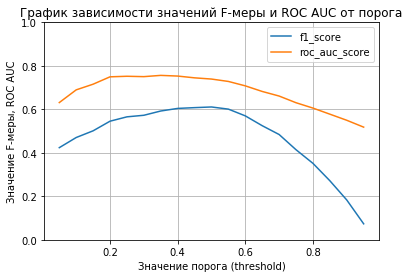

- Наибольшее значение F-меры на валидационной выборке = 0.611 при величине порога = 0.50
- Наибольшее значение ROC AUC на валидационной выборке = 0.756 при величине порога = 0.35
KNeighborsClassifier


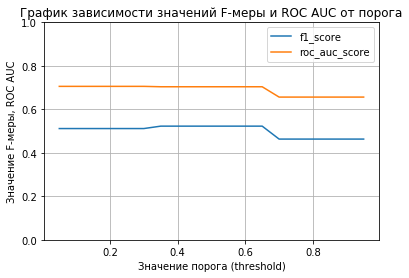

- Наибольшее значение F-меры на валидационной выборке = 0.523 при величине порога = 0.35
- Наибольшее значение ROC AUC на валидационной выборке = 0.706 при величине порога = 0.05
LogisticRegression


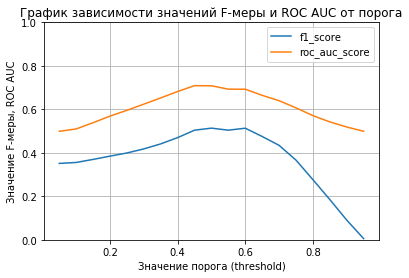

- Наибольшее значение F-меры на валидационной выборке = 0.514 при величине порога = 0.50
- Наибольшее значение ROC AUC на валидационной выборке = 0.709 при величине порога = 0.45
CatBoostClassifier


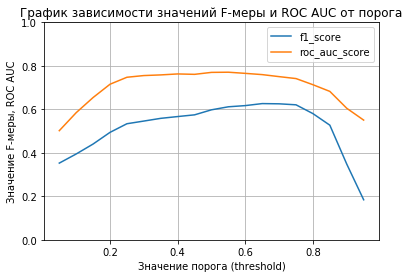

- Наибольшее значение F-меры на валидационной выборке = 0.626 при величине порога = 0.65
- Наибольшее значение ROC AUC на валидационной выборке = 0.771 при величине порога = 0.55


In [59]:
plot_f1_thresh(f1_data)

Лучший результат показала модель CatBoost.

- Наибольшее значение F-меры на валидационной выборке = 0.626 при величине порога = 0.65

### 3.3 Метод downsampling<a id='step_3.3'></a>

Уменьшим количество объектов отрицательного класса, тем самым уравняв веса классов. Воспользуемся функцией sampling написанной ранее:

In [60]:
features_ohe_downsampled, target_ohe_downsampled = sampling(features_ohe_train, target_ohe_train, how='down')
print(features_ohe_downsampled.shape)
print(target_ohe_downsampled.shape)

(2057, 11)
(2057,)


In [61]:
features_ord_downsampled, target_ord_downsampled = sampling(features_ord_train, target_ord_train, how='down')
print(features_ord_downsampled.shape)
print(target_ord_downsampled.shape)

(2057, 10)
(2057,)


### 3.4 Поиск наилучшей модели на обучении downsampled выборки<a id='step_3.4'></a>

Отлично. Теперь обучим модели на наших выборках и оценим максимальный f1_score!

In [62]:
best_model_params_ds, f1_data_ds = fit_models(features_ohe_downsampled, target_ohe_downsampled, 
                                              features_ohe_valid, target_ohe_valid,
                                              features_ord_downsampled, target_ord_downsampled, 
                                              features_ord_valid, target_ord_valid,
                                              params_lst)

0:	learn: 0.5252381	total: 2.07ms	remaining: 6.22ms
1:	learn: 0.4773718	total: 3.21ms	remaining: 3.21ms
2:	learn: 0.4588190	total: 5.12ms	remaining: 1.71ms
3:	learn: 0.4491262	total: 7.36ms	remaining: 0us
0:	learn: 0.5189329	total: 3.72ms	remaining: 11.2ms
1:	learn: 0.4666810	total: 7.37ms	remaining: 7.37ms
2:	learn: 0.4444055	total: 11.4ms	remaining: 3.79ms
3:	learn: 0.4362645	total: 14.8ms	remaining: 0us
0:	learn: 0.5199427	total: 1.16ms	remaining: 3.49ms
1:	learn: 0.4905711	total: 3.06ms	remaining: 3.06ms
2:	learn: 0.4699108	total: 4.06ms	remaining: 1.35ms
3:	learn: 0.4612171	total: 5.09ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6104806	total: 930us	remaining: 5.58ms
1:	learn: 0.6667392	total: 1.75ms	remaining: 4.39ms
2:	learn: 0.9746404	total: 2.75ms	remaining: 3.66ms
3:	learn: 2.4974238	total: 3.43ms	remaining: 2.57ms
4:	learn: 5.3017319	total: 4.11ms	remaining: 1.64ms
5:	learn: 9.4105138	total: 4.77ms	remaining: 795us
6:	learn: 3.6605698	total: 5.43ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5447580	total: 850us	remaining: 5.1ms
1:	learn: 0.5372490	total: 1.55ms	remaining: 3.88ms
2:	learn: 0.5200788	total: 2.27ms	remaining: 3.02ms
3:	learn: 0.5187051	total: 2.9ms	remaining: 2.17ms
4:	learn: 0.5041896	total: 4.94ms	remaining: 1.98ms
5:	learn: 0.4934729	total: 6.21ms	remaining: 1.03ms
6:	learn: 0.4835944	total: 8.25ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5655858	total: 844us	remaining: 5.07ms
1:	learn: 0.5591839	total: 2.36ms	remaining: 5.91ms
2:	learn: 0.5530721	total: 3.07ms	remaining: 4.09ms
3:	learn: 0.5435996	total: 3.75ms	remaining: 2.81ms
4:	learn: 0.5491876	total: 4.45ms	remaining: 1.78ms
5:	learn: 0.5232205	total: 5.1ms	remaining: 849us
6:	learn: 0.5114451	total: 5.81ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7931012	total: 1.46ms	remaining: 10.2ms
1:	learn: 3.2968029	total: 3.24ms	remaining: 9.72ms
2:	learn: 5.6940238	total: 4.46ms	remaining: 7.44ms
3:	learn: 5.4660104	total: 5.66ms	remaining: 5.66ms
4:	learn: 5.6127310	total: 6.94ms	remaining: 4.16ms
5:	learn: 6.7855732	total: 8.2ms	remaining: 2.73ms
6:	learn: 5.5910356	total: 9.52ms	remaining: 1.36ms
7:	learn: 6.4820169	total: 16.5ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7907941	total: 2.26ms	remaining: 15.8ms
1:	learn: 1.6213777	total: 4.11ms	remaining: 12.3ms
2:	learn: 2.5610886	total: 5.74ms	remaining: 9.57ms
3:	learn: 2.8621734	total: 7.14ms	remaining: 7.14ms
4:	learn: 2.0860736	total: 9.49ms	remaining: 5.7ms
5:	learn: 2.3051143	total: 12.1ms	remaining: 4.03ms
6:	learn: 2.3692939	total: 15ms	remaining: 2.14ms
7:	learn: 2.3968608	total: 49.2ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.8819307	total: 2.14ms	remaining: 15ms
1:	learn: 3.3895153	total: 3.43ms	remaining: 10.3ms
2:	learn: 7.0795155	total: 4.75ms	remaining: 7.91ms
3:	learn: 5.0300444	total: 6.45ms	remaining: 6.45ms
4:	learn: 3.9537204	total: 7.84ms	remaining: 4.7ms
5:	learn: 3.6183728	total: 9.1ms	remaining: 3.03ms
6:	learn: 3.3602378	total: 15.7ms	remaining: 2.25ms
7:	learn: 3.1856355	total: 94ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6811552	total: 1.69ms	remaining: 13.6ms
1:	learn: 0.6064757	total: 4.43ms	remaining: 15.5ms
2:	learn: 0.4890129	total: 7.24ms	remaining: 14.5ms
3:	learn: 0.5648602	total: 9.5ms	remaining: 11.9ms
4:	learn: 0.3854082	total: 11.9ms	remaining: 9.51ms
5:	learn: 0.3667427	total: 35.5ms	remaining: 17.8ms
6:	learn: 0.4019384	total: 38ms	remaining: 10.9ms
7:	learn: 0.5754297	total: 42ms	remaining: 5.25ms
8:	learn: 1.3662422	total: 44.4ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6781214	total: 1.48ms	remaining: 11.8ms
1:	learn: 1.2757560	total: 4.51ms	remaining: 15.8ms
2:	learn: 0.9219613	total: 7.06ms	remaining: 14.1ms
3:	learn: 0.8383421	total: 9.53ms	remaining: 11.9ms
4:	learn: 0.6549708	total: 12ms	remaining: 9.61ms
5:	learn: 0.6075802	total: 19.6ms	remaining: 9.78ms
6:	learn: 0.4733777	total: 92.8ms	remaining: 26.5ms
7:	learn: 0.4185423	total: 95.4ms	remaining: 11.9ms
8:	learn: 0.4107995	total: 98ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7381381	total: 1.52ms	remaining: 12.2ms
1:	learn: 0.7615859	total: 4.53ms	remaining: 15.9ms
2:	learn: 0.5075792	total: 7.07ms	remaining: 14.1ms
3:	learn: 0.5088922	total: 10ms	remaining: 12.5ms
4:	learn: 0.3607780	total: 14.1ms	remaining: 11.3ms
5:	learn: 0.3779966	total: 29.6ms	remaining: 14.8ms
6:	learn: 0.3481779	total: 32.3ms	remaining: 9.22ms
7:	learn: 0.2894041	total: 34.9ms	remaining: 4.37ms
8:	learn: 0.2848107	total: 38.2ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.0354951	total: 2.63ms	remaining: 13.2ms
1:	learn: 4.3847822	total: 6.03ms	remaining: 12.1ms
2:	learn: 5.4855841	total: 9.19ms	remaining: 9.19ms
3:	learn: 3.4344085	total: 12.5ms	remaining: 6.25ms
4:	learn: 4.2173842	total: 14.2ms	remaining: 2.85ms
5:	learn: 3.1554479	total: 21.1ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.0328142	total: 1.5ms	remaining: 7.51ms
1:	learn: 2.2768204	total: 3.43ms	remaining: 6.85ms
2:	learn: 3.3215356	total: 5.1ms	remaining: 5.1ms
3:	learn: 2.2653208	total: 6.9ms	remaining: 3.45ms
4:	learn: 2.0723094	total: 8.69ms	remaining: 1.74ms
5:	learn: 2.0632555	total: 11ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.1925759	total: 2.01ms	remaining: 10ms
1:	learn: 6.4526391	total: 5.81ms	remaining: 11.6ms
2:	learn: 7.5934298	total: 8.09ms	remaining: 8.09ms
3:	learn: 4.7916715	total: 11.7ms	remaining: 5.87ms
4:	learn: 3.3807357	total: 16.2ms	remaining: 3.25ms
5:	learn: 3.3777845	total: 21ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7931012	total: 1.46ms	remaining: 7.29ms
1:	learn: 2.5021808	total: 3.36ms	remaining: 6.73ms
2:	learn: 2.9725233	total: 5.13ms	remaining: 5.13ms
3:	learn: 2.1201788	total: 6.76ms	remaining: 3.38ms
4:	learn: 3.0741544	total: 9.66ms	remaining: 1.93ms
5:	learn: 2.3460726	total: 12.5ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7907941	total: 1.54ms	remaining: 7.71ms
1:	learn: 0.7938537	total: 3.5ms	remaining: 7ms
2:	learn: 0.9146043	total: 5.32ms	remaining: 5.32ms
3:	learn: 0.7094415	total: 7.31ms	remaining: 3.65ms
4:	learn: 0.6991404	total: 9.79ms	remaining: 1.96ms
5:	learn: 0.6713861	total: 12ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.8819307	total: 1.5ms	remaining: 7.53ms
1:	learn: 2.7072532	total: 3.3ms	remaining: 6.6ms
2:	learn: 4.5803698	total: 5.26ms	remaining: 5.26ms
3:	learn: 3.5137729	total: 7.13ms	remaining: 3.56ms
4:	learn: 2.9709967	total: 8.93ms	remaining: 1.79ms
5:	learn: 3.6874871	total: 10.7ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.1613011	total: 1.21ms	remaining: 6.04ms
1:	learn: 8.3632651	total: 2.4ms	remaining: 4.8ms
2:	learn: 19.3724702	total: 3.44ms	remaining: 3.44ms
3:	learn: 20.3143351	total: 4.48ms	remaining: 2.24ms
4:	learn: 13.2664497	total: 5.48ms	remaining: 1.09ms
5:	learn: 10.2578487	total: 6.5ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.1579570	total: 1.25ms	remaining: 6.24ms
1:	learn: 8.8651216	total: 2.32ms	remaining: 4.64ms
2:	learn: 20.7751625	total: 3.42ms	remaining: 3.42ms
3:	learn: 14.1658555	total: 4.4ms	remaining: 2.2ms
4:	learn: 13.5321725	total: 5.41ms	remaining: 1.08ms
5:	learn: 11.7932084	total: 6.52ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.3530205	total: 1.15ms	remaining: 5.74ms
1:	learn: 17.4204274	total: 2.29ms	remaining: 4.58ms
2:	learn: 18.9877933	total: 3.29ms	remaining: 3.29ms
3:	learn: 10.2559430	total: 4.31ms	remaining: 2.16ms
4:	learn: 19.2667696	total: 5.37ms	remaining: 1.07ms
5:	learn: 14.0005820	total: 6.37ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7397563	total: 678us	remaining: 2.71ms
1:	learn: 2.3658587	total: 1.48ms	remaining: 2.22ms
2:	learn: 4.2480297	total: 2.11ms	remaining: 1.4ms
3:	learn: 37.9608591	total: 2.71ms	remaining: 676us
4:	learn: 43.9707619	total: 4.02ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7121247	total: 750us	remaining: 3ms
1:	learn: 1.5911338	total: 1.4ms	remaining: 2.1ms
2:	learn: 4.5176507	total: 2.01ms	remaining: 1.34ms
3:	learn: 6.3244394	total: 2.64ms	remaining: 660us
4:	learn: 41.2618838	total: 3.24ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.7050368	total: 708us	remaining: 2.83ms
1:	learn: 1.3683504	total: 1.53ms	remaining: 2.29ms
2:	learn: 2.6497870	total: 2.06ms	remaining: 1.38ms
3:	learn: 3.0825594	total: 2.64ms	remaining: 660us
4:	learn: 43.1209893	total: 3.19ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6104806	total: 856us	remaining: 1.71ms
1:	learn: 0.6667392	total: 1.65ms	remaining: 822us
2:	learn: 0.9746404	total: 2.31ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5447580	total: 831us	remaining: 1.66ms
1:	learn: 0.5372490	total: 1.74ms	remaining: 869us
2:	learn: 0.5200788	total: 2.46ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5655858	total: 1.4ms	remaining: 2.8ms
1:	learn: 0.5591839	total: 2.2ms	remaining: 1.1ms
2:	learn: 0.5530721	total: 2.9ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5834486	total: 3.02ms	remaining: 9.07ms
1:	learn: 0.5343200	total: 7.42ms	remaining: 7.42ms
2:	learn: 0.4772963	total: 10.8ms	remaining: 3.59ms
3:	learn: 0.4475743	total: 14ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5788116	total: 3.61ms	remaining: 10.8ms
1:	learn: 0.5615532	total: 7.39ms	remaining: 7.39ms
2:	learn: 0.5512217	total: 10.6ms	remaining: 3.54ms
3:	learn: 0.5065927	total: 13.9ms	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.6121748	total: 1.62ms	remaining: 4.87ms
1:	learn: 0.5880069	total: 4.54ms	remaining: 4.54ms
2:	learn: 0.5330882	total: 7.79ms	remaining: 2.6ms
3:	learn: 0.4654297	total: 10.6ms	remaining: 0us
0:	learn: 0.5221182	total: 2.16ms	remaining: 6.47ms
1:	learn: 0.4784502	total: 6.5ms	remaining: 6.5ms
2:	learn: 0.4588547	total: 10.1ms	remaining: 3.38ms
3:	learn: 0.4518713	total: 14ms	remaining: 0us


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Смотрим подобранные параметры:

In [63]:
best_model_params_ds

{'RandomForestClassifier': {'n_estimators': 76,
  'min_samples_split': 14,
  'min_samples_leaf': 15,
  'max_depth': 17},
 'KNeighborsClassifier': {'n_neighbors': 5,
  'leaf_size': 20,
  'algorithm': 'brute'},
 'LogisticRegression': {'solver': 'saga',
  'penalty': 'l2',
  'max_iter': 120,
  'class_weight': None},
 'CatBoostClassifier': {'learning_rate': 1, 'iterations': 4, 'depth': 5}}

Строим график зависимости F-меры и ROC AUC от порога:

RandomForestClassifier


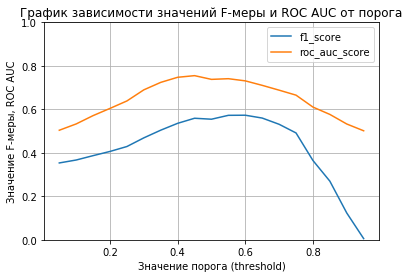

- Наибольшее значение F-меры на валидационной выборке = 0.573 при величине порога = 0.60
- Наибольшее значение ROC AUC на валидационной выборке = 0.755 при величине порога = 0.45
KNeighborsClassifier


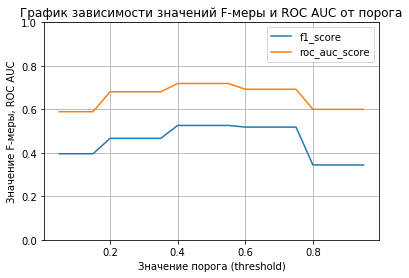

- Наибольшее значение F-меры на валидационной выборке = 0.526 при величине порога = 0.40
- Наибольшее значение ROC AUC на валидационной выборке = 0.719 при величине порога = 0.40
LogisticRegression


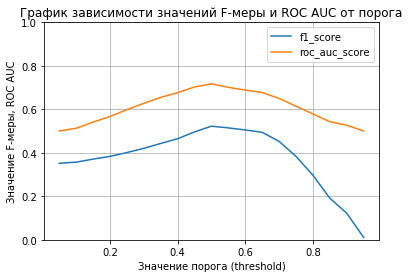

- Наибольшее значение F-меры на валидационной выборке = 0.523 при величине порога = 0.50
- Наибольшее значение ROC AUC на валидационной выборке = 0.717 при величине порога = 0.50
CatBoostClassifier


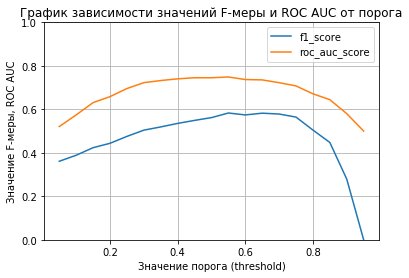

- Наибольшее значение F-меры на валидационной выборке = 0.583 при величине порога = 0.55
- Наибольшее значение ROC AUC на валидационной выборке = 0.749 при величине порога = 0.55


In [64]:
plot_f1_thresh(f1_data_ds)

### Вывод:

Судя по проведенным экспрериментам - моделям чуть лучше удается выявлять закономерности на выборках большего размера (upsampled выборках).

Наиболее высокое значение F-меры демонстрирует модель CatBoost обученная на upsampled выборке. 

На данный момент, лучшие результаты, которых добилась модель это:

- Наибольшее значение F-меры = 0.626 при величине порога = 0.65

Финально продолжим улучшать модель CatBoost показавшую наиболее высокие результы.

## 4. Тестирование модели<a id='step_4'></a>

#### Проверяем качество лучшей модели на тестовой выборке

Наиболее качественный результат показала модель CatBoostClassifier обученная на upsampled выборке. Сейчас, будем тестировать такую модель с подобранными выше параметрами на тестовой выборке:

In [65]:
model = CatBoostClassifier(learning_rate=1, iterations=4, depth=5, random_state=42)

In [66]:
model.fit(features_ord_upsampled, target_ord_upsampled)

0:	learn: 0.5192049	total: 7.99ms	remaining: 24ms
1:	learn: 0.4794812	total: 17.8ms	remaining: 17.8ms
2:	learn: 0.4558222	total: 33ms	remaining: 11ms
3:	learn: 0.4483606	total: 38.8ms	remaining: 0us


In [67]:
prediction_proba = model.predict_proba(features_ord_test)[:, -1]

In [68]:
prediction = np.where(prediction_proba > 0.65, 1, 0)

In [69]:
f1_score(target_ord_test, prediction)

0.6119402985074627

### Вывод:

Лучшие результаты которых удалось достичь в ходе обучения модели:

- Наибольшее значение F-меры = 0.611 при величине порога = 0.65

## Общий вывод:<a id='step_5'></a>

По результатм проведенного исследования выявлено:

- Модель обученная на выборке без учета дисбаланса классов - показала лучший f1-score на валидационной выборке, но худший на тестовой. Значит, учет дисбаланса помогает модели лучше видеть законометрности и вести себя более стабильно.
- Чуть более высоких значений F-меры удалось добиться на upsampled выборках. Возможно, это не закономерность, а только частный случай.
- Более высокие показатели F-меры демонстрируют модели CatBoostClassifier. 
- Более точных результатов прогноза удается добиться с помощью поиска оптимального порога классификации.

Дополнительно, на задворках проекта, аналогичным образом были обучены модели на выборках с учетом выбросов. Объекты с аномальными объектами были отброшены. Результаты оказались даже хуже, чем у моделей обученных на выборках без учета дисбаланса. В силу этого, данные результаты в проекте не представлены.